# 2D Ising model using Metropolis algorithm

In [1]:
%load_ext cython

In [2]:
%%cython


from libc.stdlib cimport rand, RAND_MAX
from libc.math cimport exp,fabs
cimport cython
import numpy as np
'''
@cython.cdivision(True)
@cython.boundscheck(False)
@cython.wraparound(False)  
def MC1(int n, double step, double xinit, double[:] x):
    x[0] = xinit;
    cdef double r,xtest,dx
    cdef int i = 0;
    
    for i in range(1,n):
        dx = 2*( rand() % 2 - 0.5) * step
        xtest = x[i-1] + dx
        r = exp( x[i-1]**2 - xtest**2 )
        if ( r >= 1):
            x[i] = xtest
        elif( r < 1):
            if ( r > float(rand())/RAND_MAX ):
                x[i] = xtest
            else:
                x[i] = x[i-1]
'''       
    
@cython.cdivision(True)
@cython.boundscheck(False)
#@cython.wraparound(False)  # DONT UNCOMMENT
def Ising(int N, int Nt, char[:,:] s, double[:] E, double[:] E2, double[:] M, double T, double J, double B):
    cdef double dH;
    cdef double H = 0;
    cdef double mag = 0;
    cdef int i,j,k;

    H = E[0];
    mag = M[0];
    
    for k in range(1,Nt):
        for i in range(N):
            for j in range(N):
                dH = 2*s[i,j]*( J*(s[(i - 1) % N, j] + s[(i + 1) % N, j] + s[i, (j - 1) % N] + s[i, (j + 1) % N]) + B )
                r = exp(- float(dH) / T)
                if ( r >= 1 or r > float(rand())/RAND_MAX):
                    s[i,j] *= -1
                    H += dH
                    mag += 2*s[i,j]
        
        M[k] = fabs(mag);
        E[k] = H;

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm


Nt = 10000
B = 0
J = 1
Tc = J/0.4406868
print(f"Tc : {Tc}")
NT = 200
NN = 5
#Ns = [10,20,40,80,160]
Ns = [32]
Mag = np.zeros(shape = (NN,NT), dtype = np.double)
Mag2 = np.zeros(shape = (NN,NT), dtype = np.double)
Energy = np.zeros( shape = (NN,NT), dtype = np.double)
Energy2 = np.zeros( shape = (NN,NT) , dtype = np.double)

Ts = np.linspace(0.1,Tc*2,NT)
#Ts = Tc*1.1 + 1 - np.logspace(0,np.log2(Tc*1.1),NT, base = 2) 

for k,N in enumerate(Ns):
    for i,T in enumerate(tqdm(Ts)):

        #s = np.random.choice([-1,1], size = (N,N))
        s = np.ones( shape = (N,N), dtype = np.int8)

        E = np.zeros( Nt, dtype = np.double)
        E2 = np.zeros( Nt, dtype = np.double)
        M = np.zeros( Nt, dtype = np.double)

        M[0] = N*N  # Only for alligned initial condition
        H = -4*J*N*N - B*M[0]  # Only for alligned initial condition

        #M[0] = np.sum(s)
        #H = -J*np.sum( s*( np.roll(s,1,0) + np.roll(s,-1,0) + np.roll(s,1,1) + np.roll(s,-1,1) ) )  -B*M[0]

        E[0] = H
        #E2[0] = H**2

        Ising(N,Nt,s,E,E2,M,T,J,B)

        Energy[k,i] = np.mean(E[ int(Nt*0.2): ])
        Energy2[k,i] = np.mean( E[ int(Nt*0.2): ]**2 )
        Mag[k,i] = np.mean(M[ int(Nt*0.2): ])
        Mag2[k,i] = np.mean( M[ int(Nt*0.2): ]**2 )
    

Tc : 2.269185280793525


100%|██████████| 200/200 [01:17<00:00,  2.59it/s]


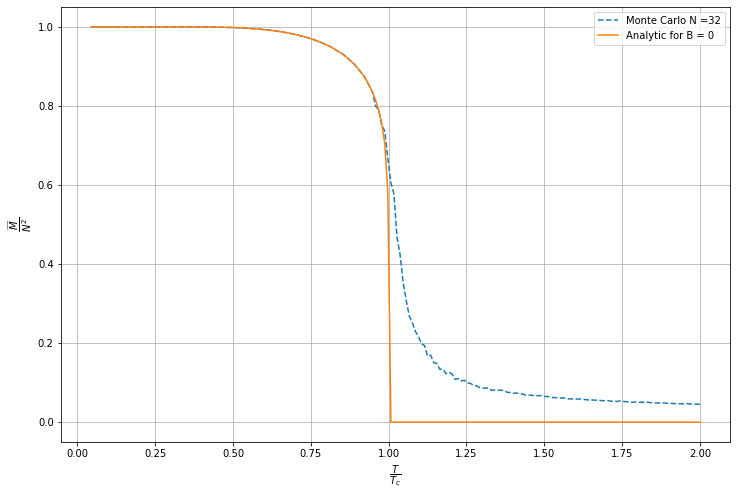

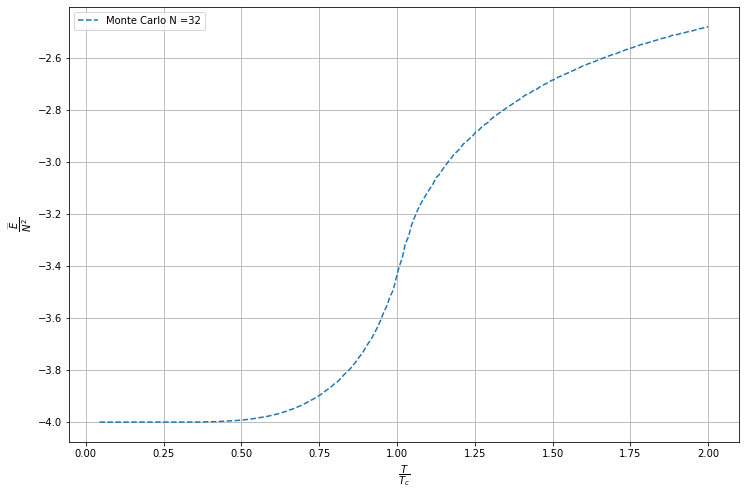

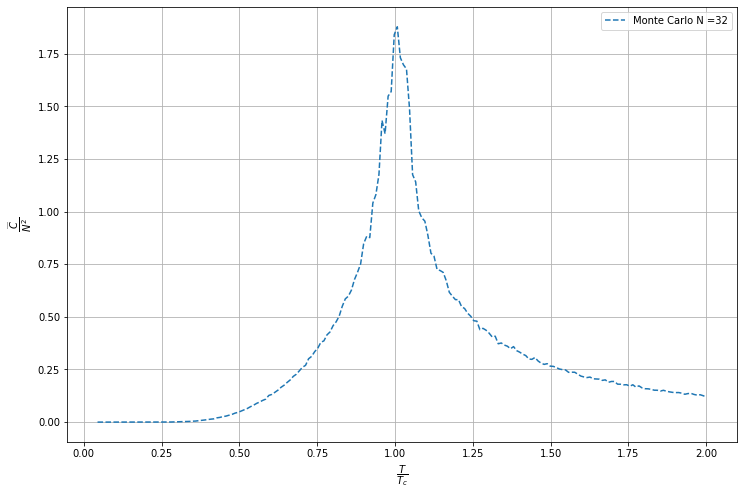

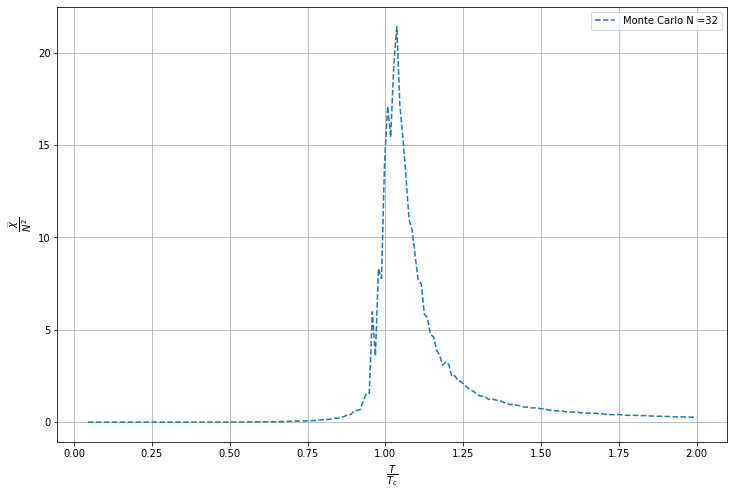

In [4]:
markers = { 0:"s",1:"o",2:"d",3:"^",4:"v"}

figure = plt.figure(figsize = (12,8))
for i,N in enumerate(Ns):
    plt.plot( Ts/Tc, Mag[i]/(N*N), "--",markerfacecolor = 'none', markersize = 5, label = f"Monte Carlo N ={N}")
y = np.zeros(NT , dtype = np.double)
index =  Ts/Tc < 1 
z = np.exp(-2*J/Ts[index])
y[index] = ((1+z**2)**(1/4) * (1-6*z**2 + z**4)**(1/8))/np.sqrt(1- z**2)
plt.plot( Ts/Tc ,y,label = "Analytic for B = 0" )
plt.xlabel(r"$\dfrac{T}{T_c}$")
plt.ylabel(r"$\dfrac{\widebar{M}}{N^2}$")
plt.legend()
plt.grid()
plt.savefig("mag.png", bbox_inches = "tight")
plt.show()
figure = plt.figure(figsize = (12,8))
for i,N in enumerate(Ns):
    plt.plot(Ts/Tc, Energy[i]/(N*N), '--', label = f"Monte Carlo N ={N}")
plt.grid()
plt.xlabel(r"$\dfrac{T}{T_c}$")
plt.ylabel(r"$\dfrac{\widebar{E}}{N^2}$")
plt.legend()

plt.savefig("energy.png", bbox_inches = "tight")

plt.show()
figure = plt.figure(figsize = (12,8))
for i,N in enumerate(Ns):
    C = (1/Ts**2)*(Energy2[i] - Energy[i]**2)
    plt.plot(Ts/Tc, C/(N*N), '--', label = f"Monte Carlo N ={N}")
plt.xlabel(r"$\dfrac{T}{T_c}$")
plt.grid()
plt.ylabel(r"$\dfrac{\widebar{C}}{N^2}$")
plt.legend()

plt.savefig("heat.png", bbox_inches = "tight")
plt.show()
figure = plt.figure(figsize = (12,8))
for i,N in enumerate(Ns):
    X = (1/Ts)*(Mag2[i] - Mag[i]**2)
    plt.plot(Ts/Tc, X/(N*N), '--', label = f"Monte Carlo N ={N}")
plt.xlabel(r"$\dfrac{T}{T_c}$")
plt.grid()
plt.ylabel(r"$\dfrac{\widebar{\chi}}{N^2}$")

plt.legend()
plt.savefig("sus.png", bbox_inches = "tight")
plt.show()


In [ ]:
"""
 M[0] = 0;
    for i in range(N):
        for j in range(N):
                M[0] += s[i,j];
    
    for i in range(1,N-1):
        for j in range(1,N-1):
            H += s[i,j]*(s[i+1,j]+s[i-1,j]+s[i,j+1]+s[i,j-1]);
    
    for i in range(1,N-1):
        H += s[i,0]*(s[i+1,0]+s[i-1,0]+s[i,1]+s[i,-1]);
        H += s[i,-1]*(s[i+1,-1]+s[i-1,-1]+s[i,0]+s[i,-2]);        
        H += s[0,i]*(s[1,i]+s[-1,i]+s[0,i+1]+s[0,i-1]);    
        H += s[-1,i]*(s[0,i]+s[-2,i]+s[-1,i+1]+s[-1,i-1]);    

    H += s[0,0]*( s[1,0] + s[0,1] + s[-1,0] + s[0,-1] );
    H += s[0,-1]*( s[0,-2] + s[0,0] + s[-1,-1] + s[1,-1] );
    H += s[-1,0]*( s[-2,0] + s[0,0] + s[-1,1] + s[-1,-1] );
    H += s[-1,-1]*( s[-2,-1] + s[0,-1] + s[-1,-2] + s[-1,0] );

    H = -J*H -B*M[0];
    
    
    
    
    
    #H = -J*np.sum( s[1:-1,1:-1]*( s[2:,1:-1] + s[:-2,1:-1] + s[1:-1,2:] + s[1:-1,:-2] ) )  -B*np.sum(s)
    #H += -J*np.sum( s[0,1:-1]*( s[-1:,1:-1] + s[1,1:-1] + s[0,2:] + s[0,:-2] ) ) 
    #H += -J*np.sum( s[-1,1:-1]*( s[-2,1:-1] + s[0,1:-1] + s[-1,2:] + s[-1,:-2] ) ) 
    #H += -J*np.sum( s[1:-1,0]*( s[1:-1,1] + s[1:-1,-1] + s[2:,0] + s[:-2,0] ) ) 
    #H += -J*np.sum( s[1:-1,-1]*( s[1:-1,0] + s[1:-1,-2] + s[2:,-1] + s[:-2,-1] ) ) 
"""
pass

## Random

In [ ]:
n = 100000000
x = np.zeros(n)
xinit = 0
step = 0.1

MC1(n,step,xinit,x)

f = x**2
Int = (1/(n))*np.sum(f)
Int*1.77245
    
    

In [ ]:
a = np.arange(-10,10,0.1)
plt.figure( figsize = (16,9)   )
plt.hist(x, bins = 200, density = True,label = "Metropolis")
plt.plot(a, np.exp(-1*a**2), label = "Gaussian")
plt.legend()
plt.show()